TASK: Forecasting bus demand in Banana Republic municipalities.

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV). 
The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values):
MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY
where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.

**The committee asks you to forecast the hourly bus usages for next week for each municipality.** 

> Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.)

---------------------------------------------------------------------------

> The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. 

---------------------------------------------------------------------------

> You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately.
Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/content/drive/MyDrive/municipality_bus_utilization.csv')
data.head(5)

timestamp  municipality_id  usage  total_capacity
0  2017-06-04 07:59:42                9    454            1332
1  2017-06-04 07:59:42                8    556            2947
2  2017-06-04 07:59:42                4   1090            3893
3  2017-06-04 07:59:42                0    204            2813
4  2017-06-04 07:59:42                7    718            2019

In [ ]:
data.timestamp.min(), data.timestamp.max()

('2017-06-04 07:59:42', '2017-08-19 16:30:35')

In [ ]:
data['total_capacity'].value_counts()

1332    1307
2947    1307
3893    1307
2813    1307
2019    1307
587     1307
697     1307
397     1307
3113    1307
1930    1307
Name: total_capacity, dtype: int64

In [ ]:
print(sorted(list(data['municipality_id'].unique())))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
data.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [ ]:
data.describe()

municipality_id         usage  total_capacity
count     13070.000000  13070.000000    13070.000000
mean          4.500000    876.002984     1972.800000
std           2.872391    679.287109     1144.074782
min           0.000000     11.000000      397.000000
25%           2.000000    403.000000      697.000000
50%           4.500000    692.000000     1974.500000
75%           7.000000   1190.000000     2947.000000
max           9.000000   3508.000000     3893.000000

# DATA EXPLORATION

In [3]:
train_data = data[data['timestamp'] < '2017-08-05 00:00:00']
test_data = data[data['timestamp'] >= '2017-08-05 00:00:00']

In [4]:
def parse_different_m_logs(data):
  dfs_train = []
  dfs_test = []
  for i in range(10):
    dfs_train.append(train_data[train_data['municipality_id'] == i].reset_index(drop=True))
    dfs_test.append(test_data[test_data['municipality_id'] == i].reset_index(drop=True))
  return dfs_train, dfs_test

In [5]:
train_data, test_data = parse_different_m_logs(data)

In [6]:
m0_train, m1_train, m2_train, m3_train, m4_train, m5_train, m6_train, m7_train, m8_train, m9_train = train_data
m0_test, m1_test, m2_test, m3_test, m4_test, m5_test, m6_test, m7_test, m8_test, m9_test = test_data

In [7]:
train_muns = [m0_train, m1_train, m2_train, m3_train, m4_train, m5_train, m6_train, m7_train, m8_train, m9_train]
test_muns = [m0_test, m1_test, m2_test, m3_test, m4_test, m5_test, m6_test, m7_test, m8_test, m9_test]

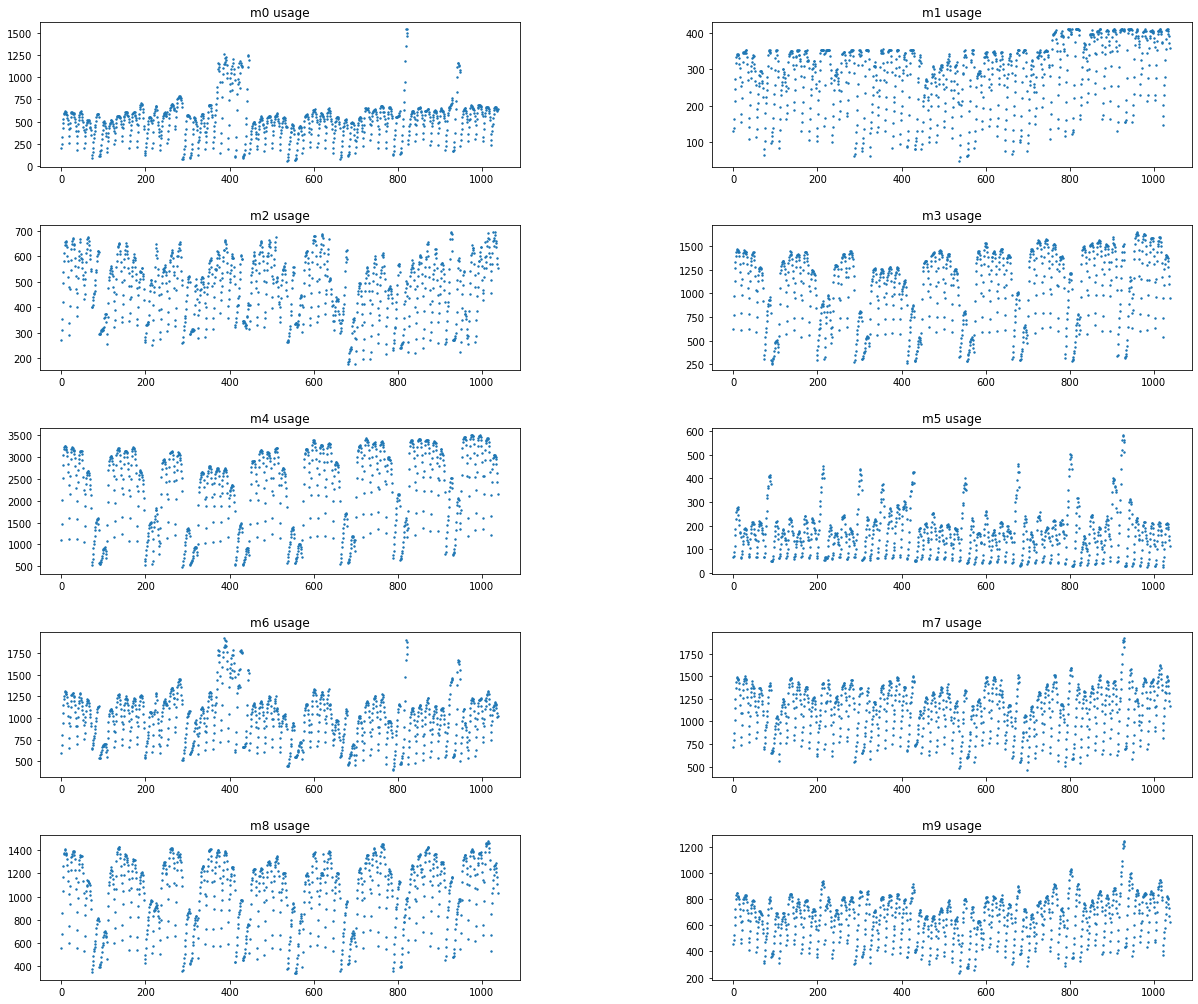

In [ ]:
plt.figure(figsize=(20,7))

for ix,i in enumerate(train_muns):
  plt.subplot(5,2,ix+1)
  plt.scatter(range(len(i)),i['usage'], s=2)

  plt.title(f'm{ix} usage')

  # set the spacing between subplots
  plt.subplots_adjust(left=0.1,
                      bottom=-1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

In [8]:
for mun in [*train_muns, *test_muns]:
  mun['hours'] = mun['timestamp'].apply(lambda x: x[:-6])

In [9]:
max_usage_per_hour = m0_train.groupby("hours").max("usage")["usage"]
m0_train = m0_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m0_train["timestamp"] = pd.to_datetime(m0_train["hours"], format='%Y-%m-%d %H')
m0_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m0_train.drop_duplicates(inplace=True)
m0_train = m0_train.set_index('timestamp')

max_usage_per_hour = m1_train.groupby("hours").max("usage")["usage"]
m1_train = m1_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m1_train["timestamp"] = pd.to_datetime(m1_train["hours"], format='%Y-%m-%d %H')
m1_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m1_train.drop_duplicates(inplace=True)
m1_train = m1_train.set_index('timestamp')

max_usage_per_hour = m2_train.groupby("hours").max("usage")["usage"]
m2_train = m2_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m2_train["timestamp"] = pd.to_datetime(m2_train["hours"], format='%Y-%m-%d %H')
m2_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m2_train.drop_duplicates(inplace=True)
m2_train = m2_train.set_index('timestamp')

max_usage_per_hour = m3_train.groupby("hours").max("usage")["usage"]
m3_train = m3_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m3_train["timestamp"] = pd.to_datetime(m3_train["hours"], format='%Y-%m-%d %H')
m3_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m3_train.drop_duplicates(inplace=True)
m3_train = m3_train.set_index('timestamp')

max_usage_per_hour = m4_train.groupby("hours").max("usage")["usage"]
m4_train = m4_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m4_train["timestamp"] = pd.to_datetime(m4_train["hours"], format='%Y-%m-%d %H')
m4_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m4_train.drop_duplicates(inplace=True)
m4_train = m4_train.set_index('timestamp')

max_usage_per_hour = m5_train.groupby("hours").max("usage")["usage"]
m5_train = m5_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m5_train["timestamp"] = pd.to_datetime(m5_train["hours"], format='%Y-%m-%d %H')
m5_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m5_train.drop_duplicates(inplace=True)
m5_train = m5_train.set_index('timestamp')

max_usage_per_hour = m6_train.groupby("hours").max("usage")["usage"]
m6_train = m6_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m6_train["timestamp"] = pd.to_datetime(m6_train["hours"], format='%Y-%m-%d %H')
m6_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m6_train.drop_duplicates(inplace=True)
m6_train = m6_train.set_index('timestamp')

max_usage_per_hour = m7_train.groupby("hours").max("usage")["usage"]
m7_train = m7_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m7_train["timestamp"] = pd.to_datetime(m7_train["hours"], format='%Y-%m-%d %H')
m7_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m7_train.drop_duplicates(inplace=True)
m7_train = m7_train.set_index('timestamp')

max_usage_per_hour = m8_train.groupby("hours").max("usage")["usage"]
m8_train = m8_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m8_train["timestamp"] = pd.to_datetime(m8_train["hours"], format='%Y-%m-%d %H')
m8_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m8_train.drop_duplicates(inplace=True)
m8_train = m8_train.set_index('timestamp')

max_usage_per_hour = m9_train.groupby("hours").max("usage")["usage"]
m9_train = m9_train.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m9_train["timestamp"] = pd.to_datetime(m9_train["hours"], format='%Y-%m-%d %H')
m9_train.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m9_train.drop_duplicates(inplace=True)
m9_train = m9_train.set_index('timestamp')

In [10]:
max_usage_per_hour = m0_test.groupby("hours").max("usage")["usage"]
m0_test = m0_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m0_test["timestamp"] = pd.to_datetime(m0_test["hours"], format='%Y-%m-%d %H')
m0_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m0_test.drop_duplicates(inplace=True)
m0_test = m0_test.set_index('timestamp')

max_usage_per_hour = m1_test.groupby("hours").max("usage")["usage"]
m1_test = m1_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m1_test["timestamp"] = pd.to_datetime(m1_test["hours"], format='%Y-%m-%d %H')
m1_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m1_test.drop_duplicates(inplace=True)
m1_test = m1_test.set_index('timestamp')

max_usage_per_hour = m2_test.groupby("hours").max("usage")["usage"]
m2_test = m2_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m2_test["timestamp"] = pd.to_datetime(m2_test["hours"], format='%Y-%m-%d %H')
m2_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m2_test.drop_duplicates(inplace=True)
m2_test = m2_test.set_index('timestamp')

max_usage_per_hour = m3_test.groupby("hours").max("usage")["usage"]
m3_test = m3_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m3_test["timestamp"] = pd.to_datetime(m3_test["hours"], format='%Y-%m-%d %H')
m3_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m3_test.drop_duplicates(inplace=True)
m3_test = m3_test.set_index('timestamp')

max_usage_per_hour = m4_test.groupby("hours").max("usage")["usage"]
m4_test = m4_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m4_test["timestamp"] = pd.to_datetime(m4_test["hours"], format='%Y-%m-%d %H')
m4_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m4_test.drop_duplicates(inplace=True)
m4_test = m4_test.set_index('timestamp')

max_usage_per_hour = m5_test.groupby("hours").max("usage")["usage"]
m5_test = m5_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m5_test["timestamp"] = pd.to_datetime(m5_test["hours"], format='%Y-%m-%d %H')
m5_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m5_test.drop_duplicates(inplace=True)
m5_test = m5_test.set_index('timestamp')

max_usage_per_hour = m6_test.groupby("hours").max("usage")["usage"]
m6_test = m6_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m6_test["timestamp"] = pd.to_datetime(m6_test["hours"], format='%Y-%m-%d %H')
m6_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m6_test.drop_duplicates(inplace=True)
m6_test = m6_test.set_index('timestamp')

max_usage_per_hour = m7_test.groupby("hours").max("usage")["usage"]
m7_test = m7_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m7_test["timestamp"] = pd.to_datetime(m7_test["hours"], format='%Y-%m-%d %H')
m7_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m7_test.drop_duplicates(inplace=True)
m7_test = m7_test.set_index('timestamp')

max_usage_per_hour = m8_test.groupby("hours").max("usage")["usage"]
m8_test = m8_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m8_test["timestamp"] = pd.to_datetime(m8_test["hours"], format='%Y-%m-%d %H')
m8_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m8_test.drop_duplicates(inplace=True)
m8_test = m8_test.set_index('timestamp')

max_usage_per_hour = m9_test.groupby("hours").max("usage")["usage"]
m9_test = m9_test.merge(max_usage_per_hour, how="left", left_on="hours", right_on="hours", suffixes=[None, '_max_per_hour'])
m9_test["timestamp"] = pd.to_datetime(m9_test["hours"], format='%Y-%m-%d %H')
m9_test.drop(columns=["usage", "hours", "municipality_id", "total_capacity"], inplace=True)
m9_test.drop_duplicates(inplace=True)
m9_test = m9_test.set_index('timestamp')

In [11]:
train_muns = [m0_train, m1_train, m2_train, m3_train, m4_train, m5_train, m6_train, m7_train, m8_train, m9_train]
test_muns = [m0_test, m1_test, m2_test, m3_test, m4_test, m5_test, m6_test, m7_test, m8_test, m9_test]

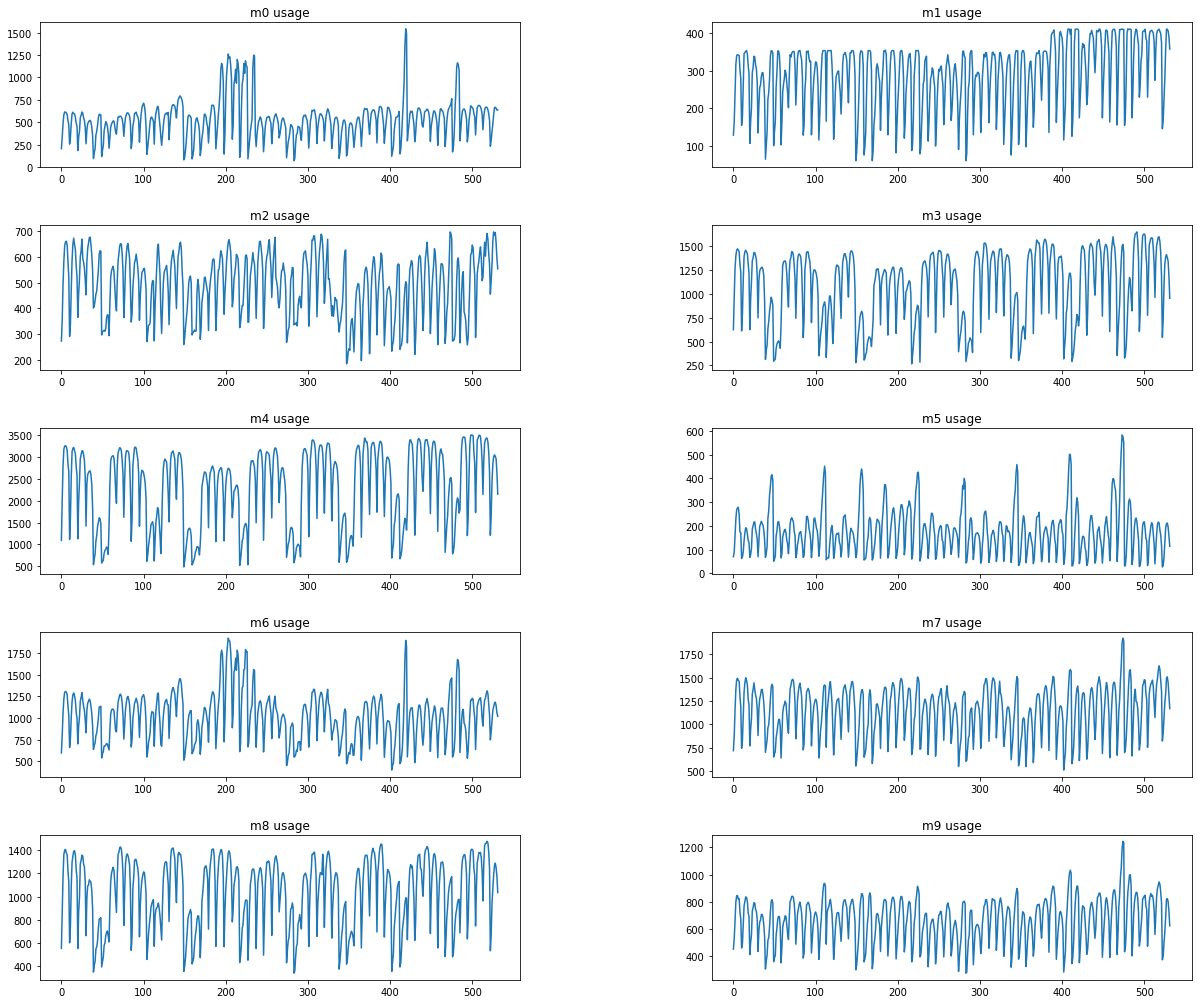

In [ ]:
plt.figure(figsize=(20,7))

for ix,i in enumerate(train_muns):
  plt.subplot(5,2,ix+1)
  plt.plot(range(len(i)),i['usage_max_per_hour'])

  plt.title(f'm{ix} usage')

  # set the spacing between subplots
  plt.subplots_adjust(left=0.1,
                      bottom=-1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

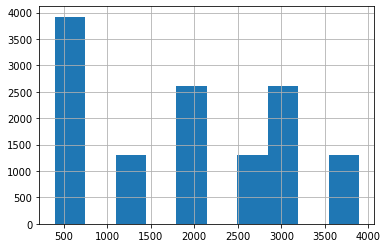

In [ ]:
data.total_capacity.hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0b34f85d0>,
      dtype=object)

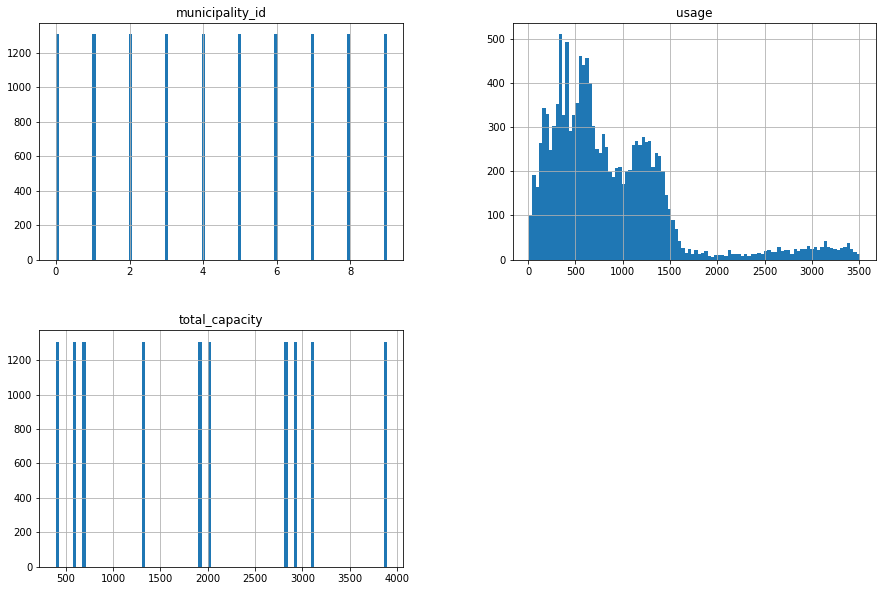

In [ ]:
data.hist(bins=100,figsize=(15,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0acd02e90>],
      dtype=object)

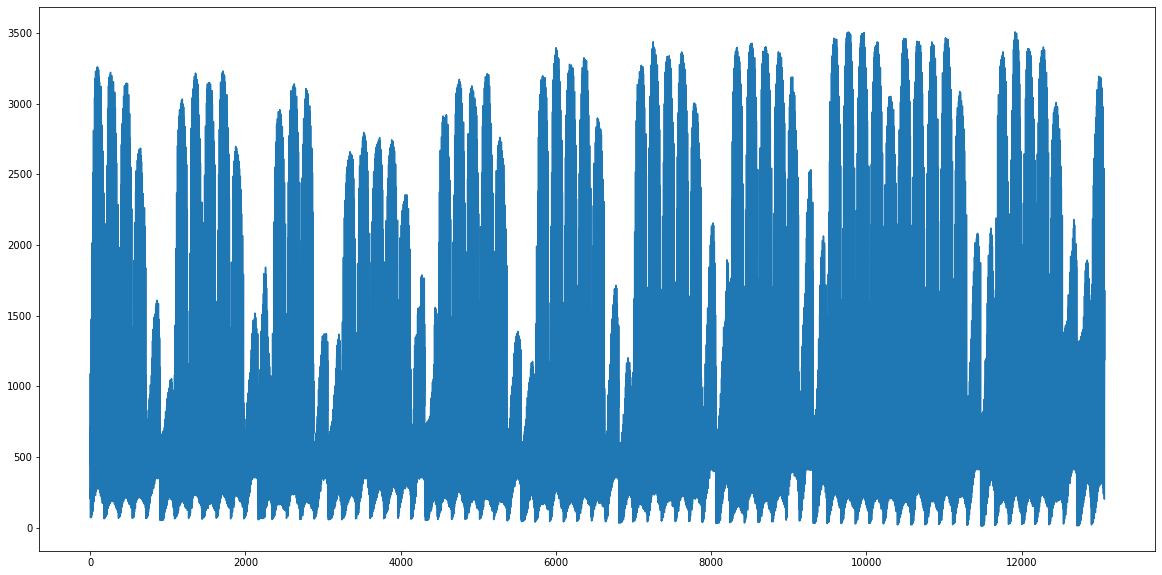

In [ ]:
data['usage'].plot(subplots=True,figsize=(20,10))

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

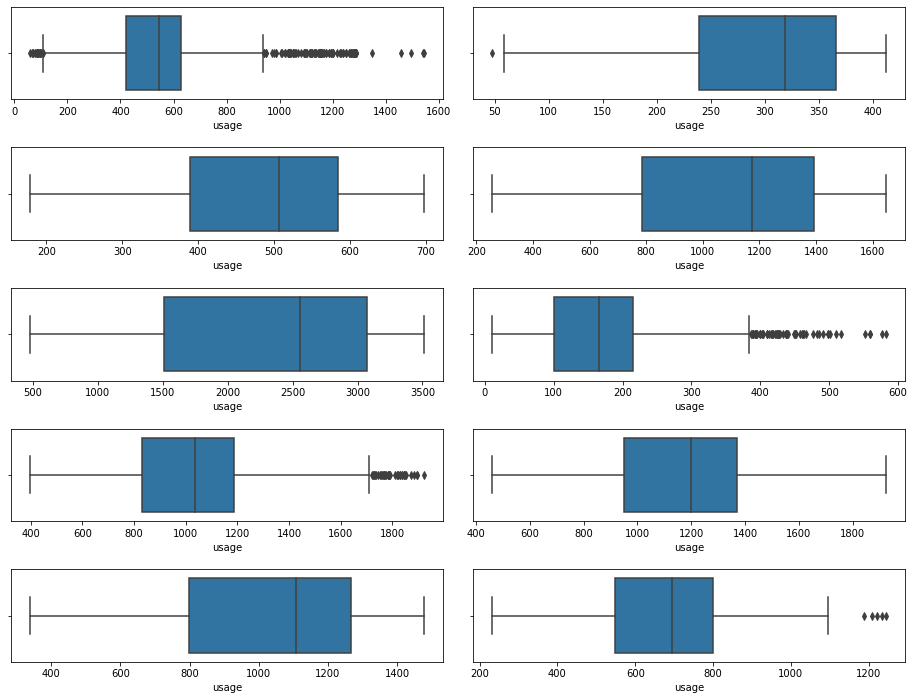

In [ ]:
plt.figure(figsize=(13,10))
plt.subplot(5,2,1)
sns.boxplot(data[data['municipality_id']==0]['usage'])

plt.subplot(5,2,2)
sns.boxplot(data[data['municipality_id']==1]['usage'])

plt.subplot(5,2,3)
sns.boxplot(data[data['municipality_id']==2]['usage'])

plt.subplot(5,2,4)
sns.boxplot(data[data['municipality_id']==3]['usage'])

plt.subplot(5,2,5)
sns.boxplot(data[data['municipality_id']==4]['usage'])

plt.subplot(5,2,6)
sns.boxplot(data[data['municipality_id']==5]['usage'])

plt.subplot(5,2,7)
sns.boxplot(data[data['municipality_id']==6]['usage'])

plt.subplot(5,2,8)
sns.boxplot(data[data['municipality_id']==7]['usage'])

plt.subplot(5,2,9)
sns.boxplot(data[data['municipality_id']==8]['usage'])

plt.subplot(5,2,10)
sns.boxplot(data[data['municipality_id']==9]['usage'])

plt.tight_layout(1.7)
plt.show()

In [ ]:
x = data['timestamp'].drop_duplicates().to_numpy()

In [ ]:
x

array(['2017-06-04 07:59:42', '2017-06-04 08:25:42',
       '2017-06-04 08:59:42', ..., '2017-08-19 15:29:33',
       '2017-08-19 16:03:35', '2017-08-19 16:30:35'], dtype=object)

In [ ]:
diff = []
for ix,i in enumerate(x):
  if ix+1 <= x.__len__()-1:
    time_1 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    time_2 = datetime.strptime(x[ix+1], "%Y-%m-%d %H:%M:%S")

    diff.append(time_2 - time_1)

    if (time_2 - time_1)/timedelta(minutes=60) < -6: # there is a -7.5 difference somewhere
      print(ix)

447


In [ ]:
x[445:451]

array(['2017-06-30 14:32:54', '2017-06-30 15:00:00',
       '2017-06-30 15:32:59', '2017-06-30 08:00:03',
       '2017-06-30 08:26:02', '2017-06-30 09:00:00'], dtype=object)

In [ ]:
x[:6]

array(['2017-06-04 07:59:42', '2017-06-04 08:25:42',
       '2017-06-04 08:59:42', '2017-06-04 09:32:46',
       '2017-06-04 09:59:48', '2017-06-04 10:26:49'], dtype=object)

In [ ]:
diff = [x/timedelta(minutes=60) for x in diff]

In [ ]:
diff_count = []
for i in set(diff):
  diff_count.append((i,diff.count(i)))

In [ ]:
diff_count.sort(key = lambda x: x[0])
diff_count[:10]

# Number of measurement days each week

In [ ]:
measurements_per_day = []
for ix, mun in enumerate(train_muns):
  mun["day"] = [str(x)[:10] for x in mun.index.to_list()]
  num_measurements_per_day = mun.groupby("day").count()
  measurements_per_day.append([f'mun {ix}' , *num_measurements_per_day['usage_max_per_hour'].value_counts().index.to_list()])

measurements_per_day

[['mun 0', 9, 10],
 ['mun 1', 9, 10],
 ['mun 2', 9, 10],
 ['mun 3', 9, 10],
 ['mun 4', 9, 10],
 ['mun 5', 9, 10],
 ['mun 6', 9, 10],
 ['mun 7', 9, 10],
 ['mun 8', 9, 10],
 ['mun 9', 9, 10]]

# CHECKING STATIONARITY FOR EACH MUNICIPALITY

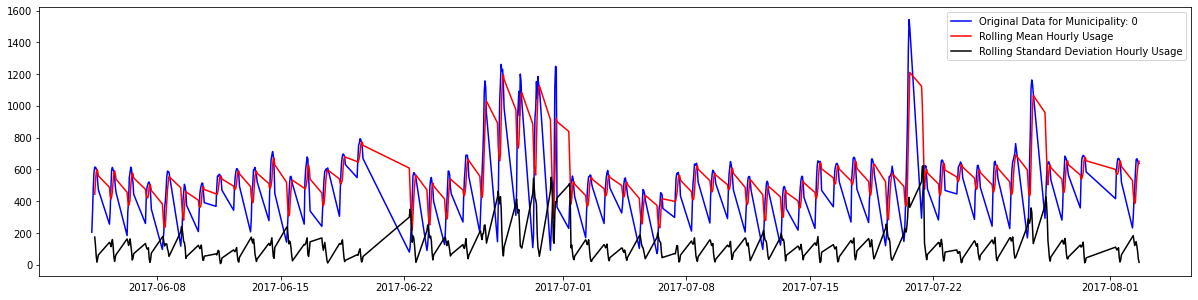

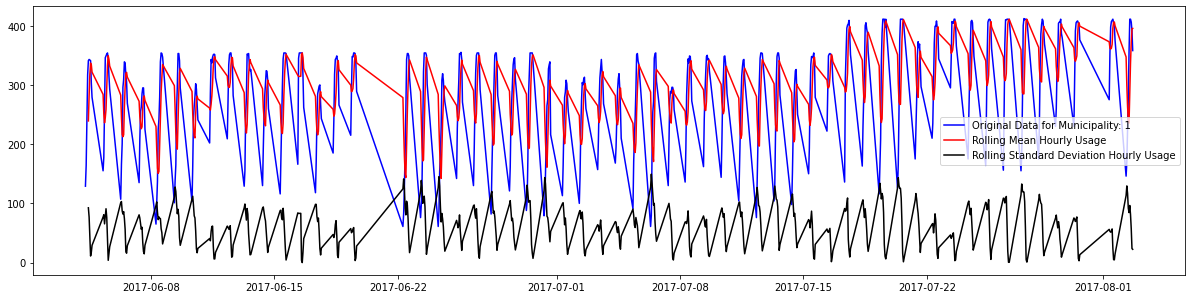

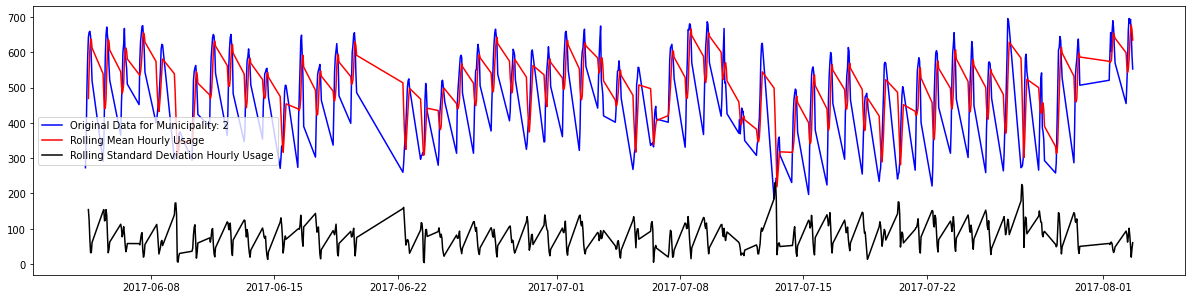

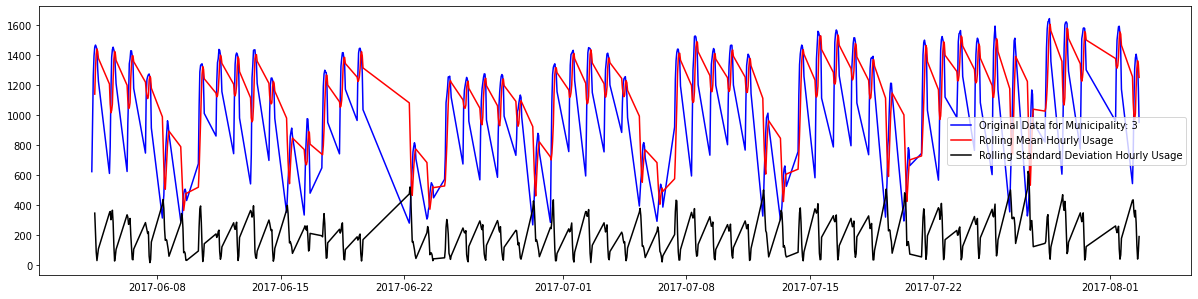

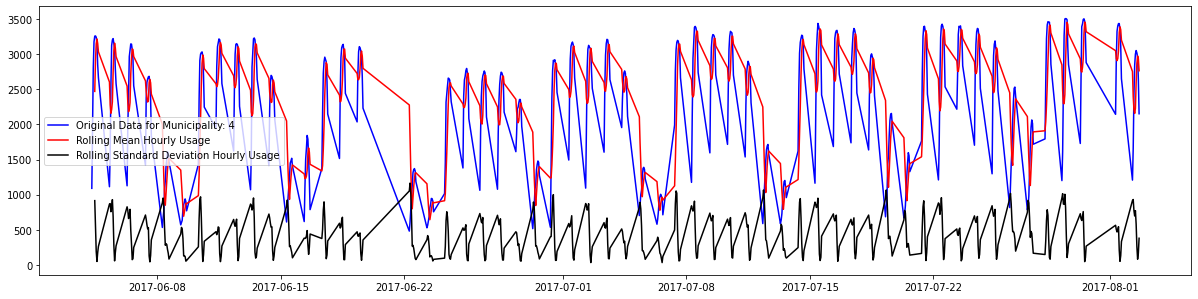

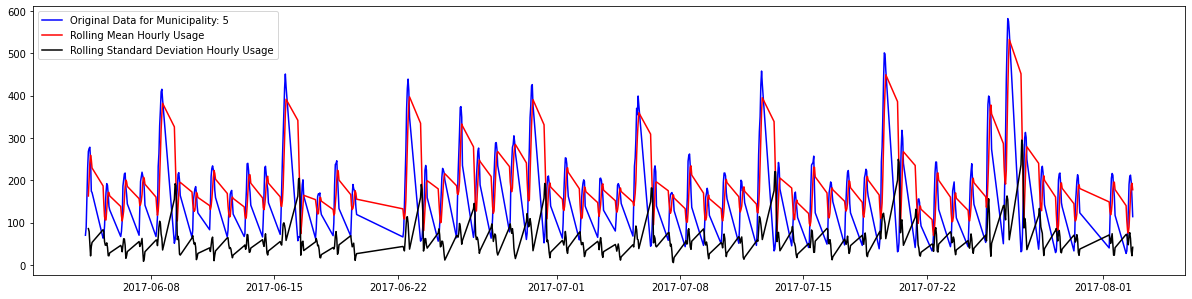

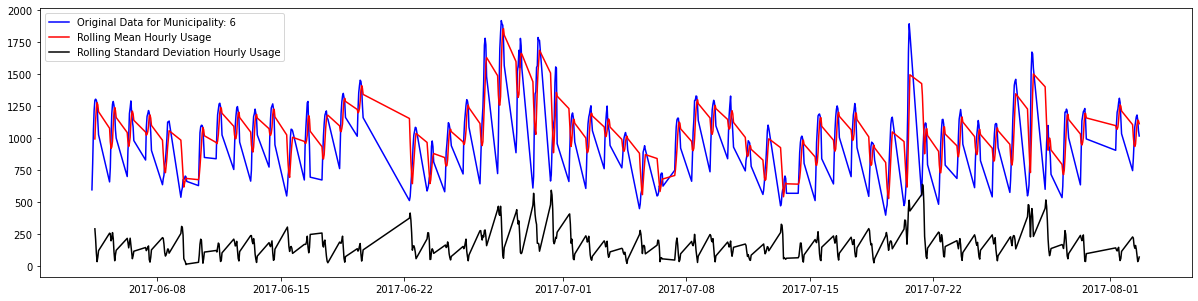

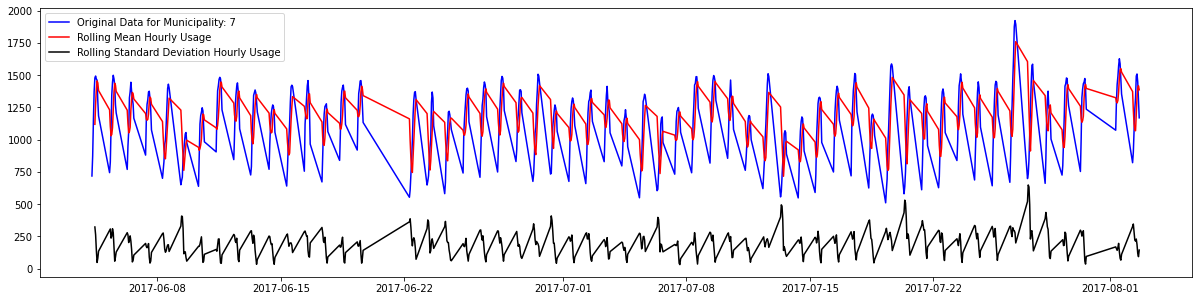

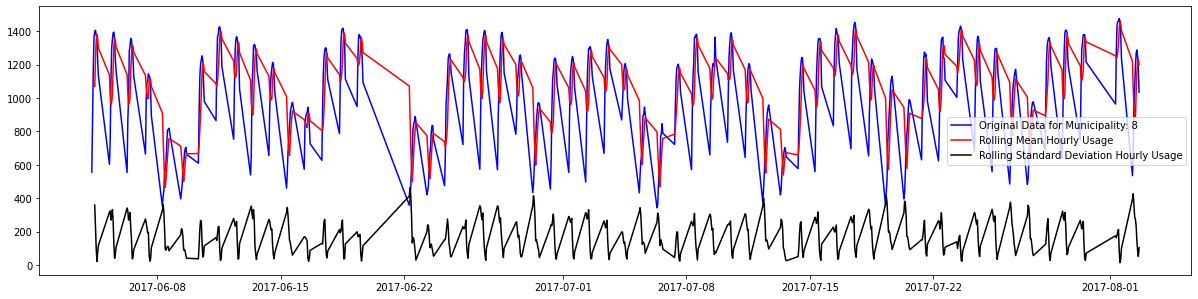

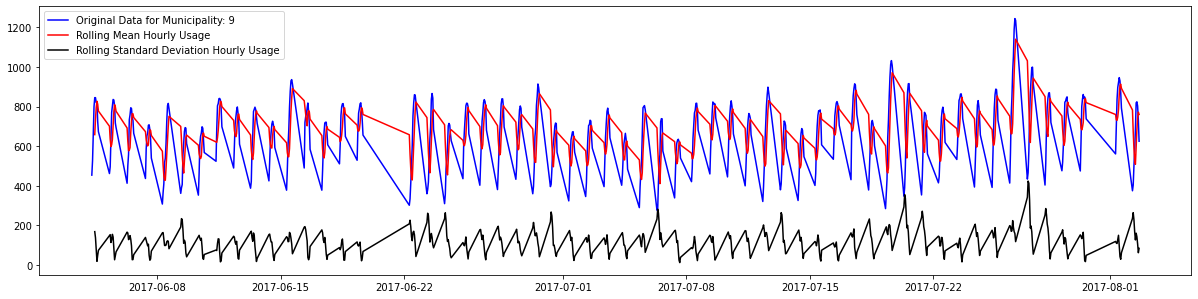

In [ ]:
for ix,mun in enumerate(train_muns):
  roll_mean = mun.rolling(5).mean()
  roll_std = mun.rolling(5).std()

  plt.figure(figsize=(20,13))
  plt.subplot(10,1,ix+1)
  plt.plot(m0_train.index, mun['usage_max_per_hour'], color="blue",label=f"Original Data for Municipality: {ix}")
  plt.plot(roll_mean, color="red", label="Rolling Mean Hourly Usage")
  plt.plot(roll_std, color="black", label = "Rolling Standard Deviation Hourly Usage")
  plt.legend(loc="best")

  # set the spacing between subplots
  plt.subplots_adjust(left=0.1,
                      bottom=-3, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

In [ ]:
from statsmodels.tsa.stattools import adfuller

for ix,mun in enumerate(train_muns):
  print(f'MUNICIPALITY {ix} ADFT RESULT:')
  adft = adfuller(mun['usage_max_per_hour'],autolag="AIC")
  output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']], 
                            "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                      "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
  print(output_df)
  print('-'*50)

MUNICIPALITY 0 ADFT RESULT:
       Values                       Metric
0   -3.184460              Test Statistics
1    0.020902                      p-value
2   19.000000             No. of lags used
3  512.000000  Number of observations used
4   -3.443187          critical value (1%)
5   -2.867202          critical value (5%)
6   -2.569785         critical value (10%)
--------------------------------------------------
MUNICIPALITY 1 ADFT RESULT:
       Values                       Metric
0   -3.293311              Test Statistics
1    0.015180                      p-value
2   10.000000             No. of lags used
3  521.000000  Number of observations used
4   -3.442964          critical value (1%)
5   -2.867103          critical value (5%)
6   -2.569733         critical value (10%)
--------------------------------------------------
MUNICIPALITY 2 ADFT RESULT:
       Values                       Metric
0   -4.590245              Test Statistics
1    0.000135                      p-val

**Note:** Our hourly usage data is stationary, as p values are lower than 5% and test statistics are lower than critial value.

# AUTOCORRELATION

In [ ]:
for ix,mun in enumerate(train_muns):
  autocorrelation = mun['usage_max_per_hour'].autocorr(lag=1)
  print(f"One Hour Lag Aautocorrelation for Municipality {ix}: ", autocorrelation)

One Hour Lag Aautocorrelation for Municipality 0:  0.7253149788476433
One Hour Lag Aautocorrelation for Municipality 1:  0.6682067991168982
One Hour Lag Aautocorrelation for Municipality 2:  0.7637578017579488
One Hour Lag Aautocorrelation for Municipality 3:  0.8096011026522254
One Hour Lag Aautocorrelation for Municipality 4:  0.8386383676649204
One Hour Lag Aautocorrelation for Municipality 5:  0.7500448393972858
One Hour Lag Aautocorrelation for Municipality 6:  0.7711176797971949
One Hour Lag Aautocorrelation for Municipality 7:  0.6957788167567067
One Hour Lag Aautocorrelation for Municipality 8:  0.7653732681323426
One Hour Lag Aautocorrelation for Municipality 9:  0.6925572430774256


**Note:** Data points in our hourly usage data seems correlated with the past datapoints.

# DECOMPOSITION

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Decomposition for Municipality 0


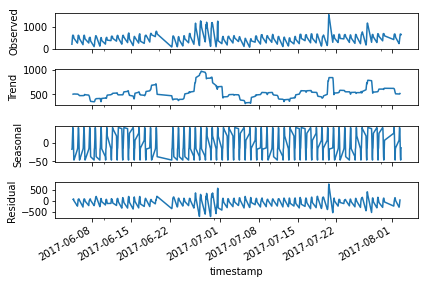

Decomposition for Municipality 1


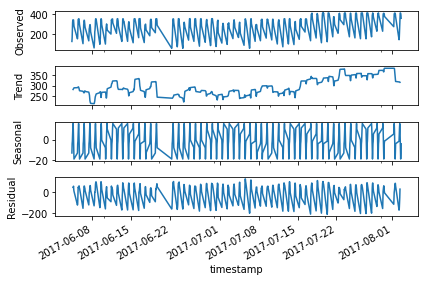

Decomposition for Municipality 2


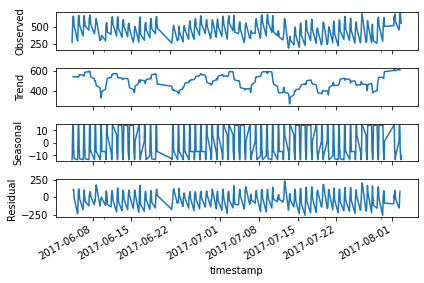

Decomposition for Municipality 3


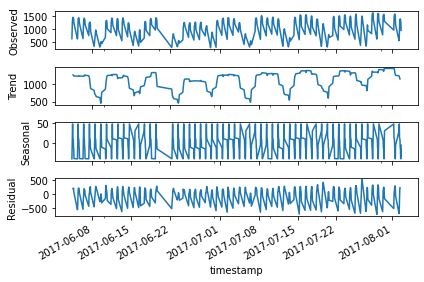

Decomposition for Municipality 4


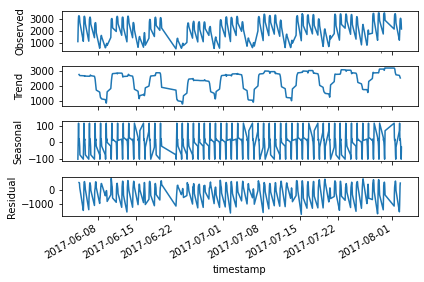

Decomposition for Municipality 5


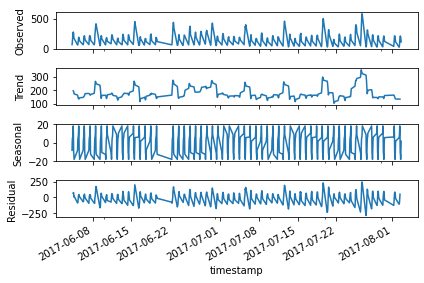

Decomposition for Municipality 6


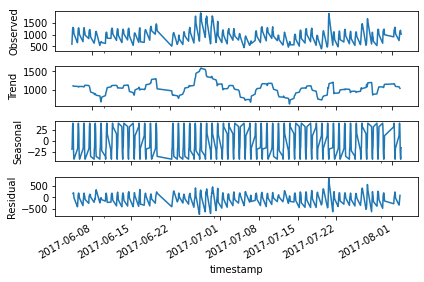

Decomposition for Municipality 7


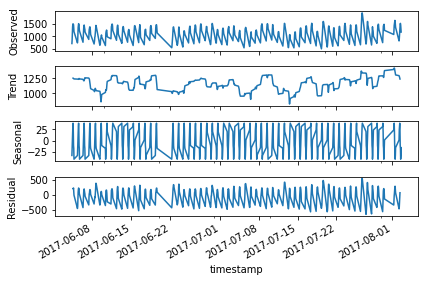

Decomposition for Municipality 8


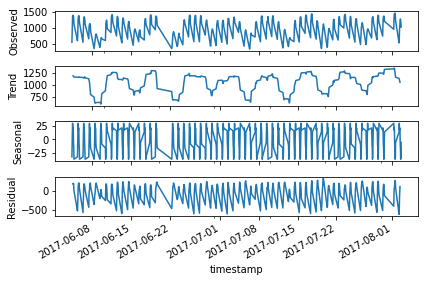

Decomposition for Municipality 9


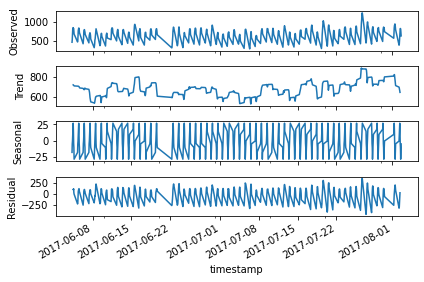

In [ ]:
for ix,mun in enumerate(train_muns):
  print(f'Decomposition for Municipality {ix}')
  decompose = seasonal_decompose(mun['usage_max_per_hour'],model='additive', freq=10)
  decompose.plot()
  plt.show()

# FORECAST WITH ARIMA

### Finding 'p' term

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


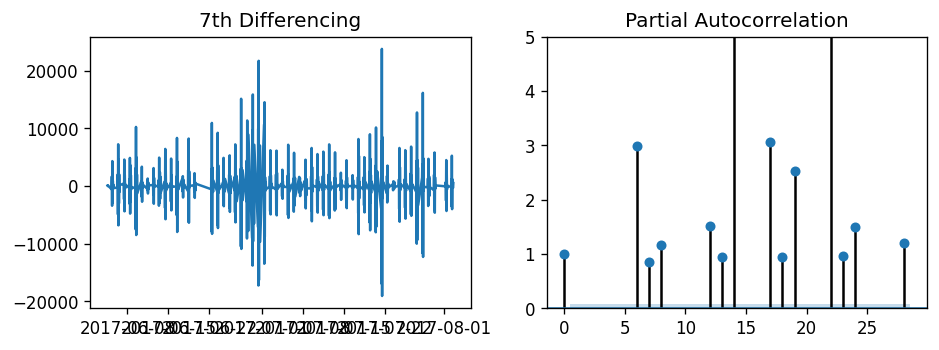

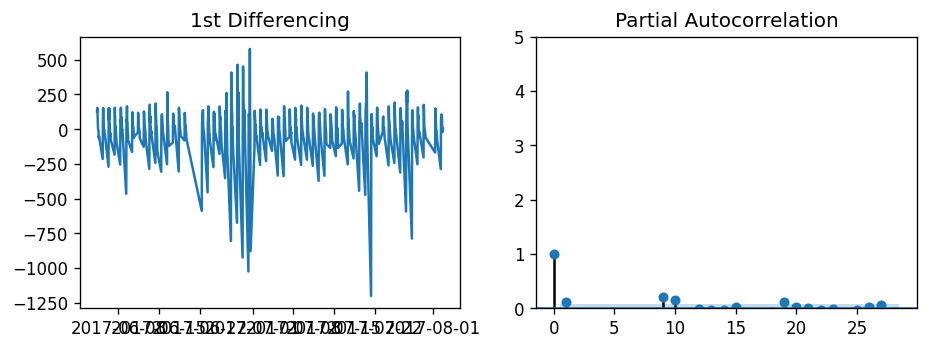

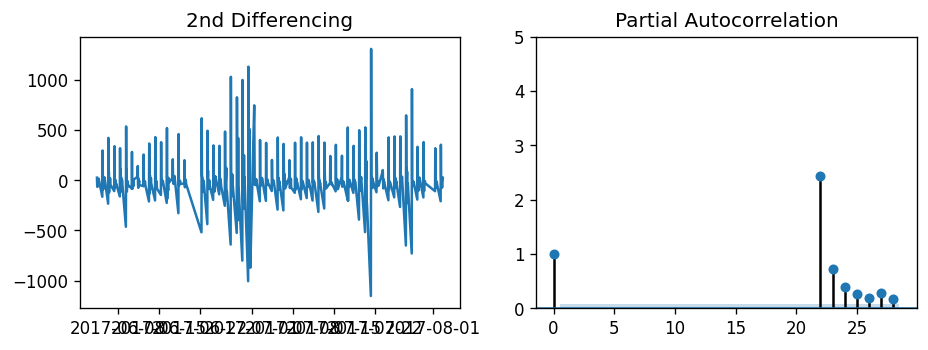

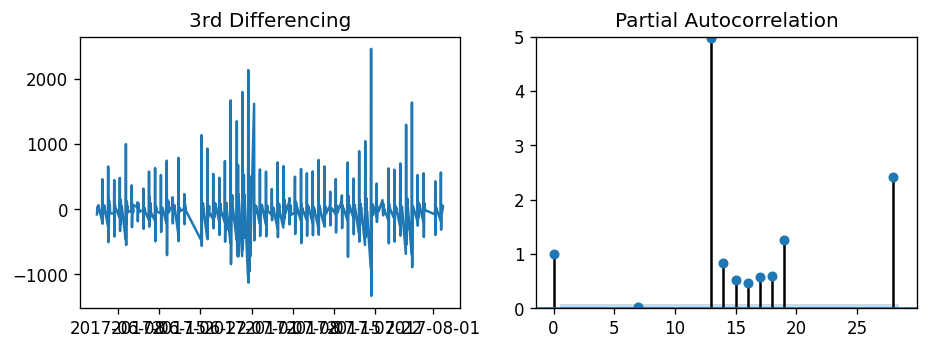

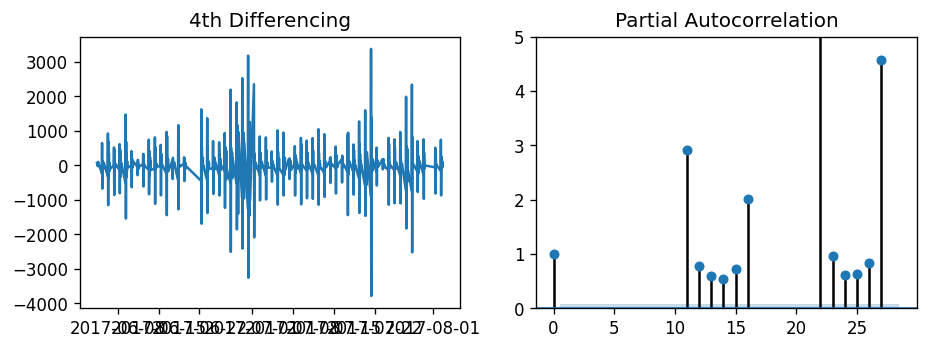

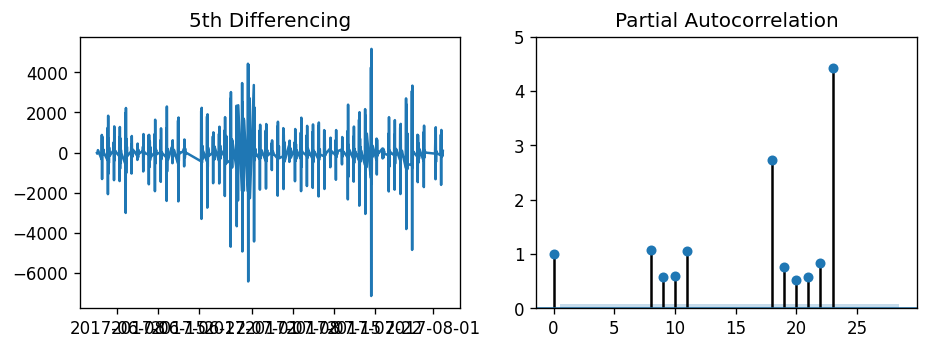

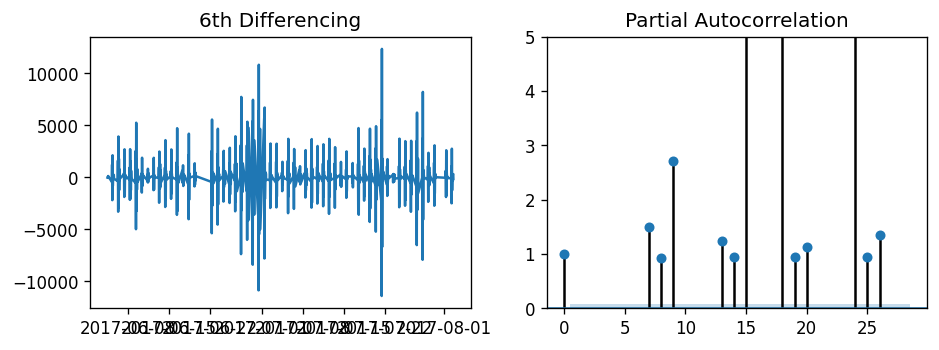

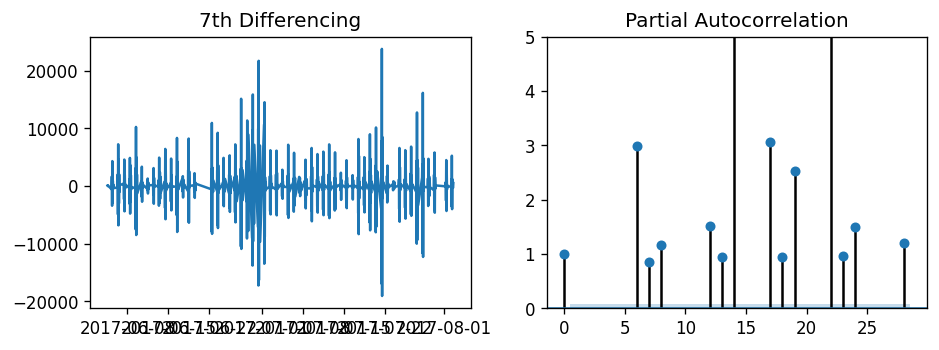

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

df = m0_train.copy()

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().diff().diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff().diff().diff()); axes[0].set_title('4th Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().diff().diff().diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff().diff().diff().diff()); axes[0].set_title('5th Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().diff().diff().diff().diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff().diff().diff().diff().diff()); axes[0].set_title('6th Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().diff().diff().diff().diff().diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff().diff().diff().diff().diff().diff()); axes[0].set_title('7th Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.usage_max_per_hour.diff().diff().diff().diff().diff().diff().diff().dropna(), ax=axes[1])

# p term is 7 for m0_train

### Finding 'q' term

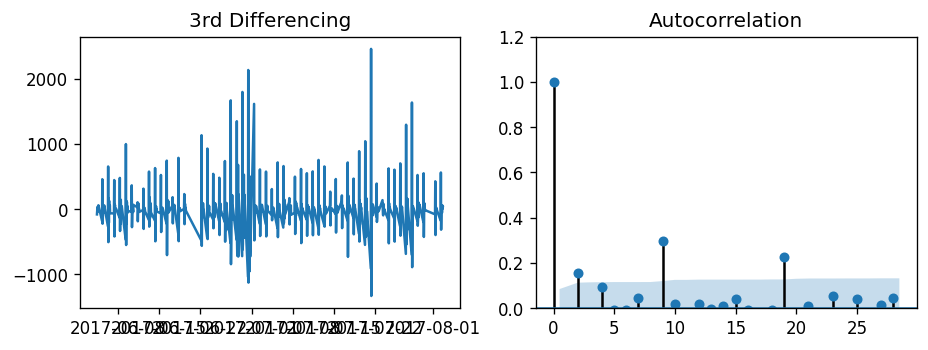

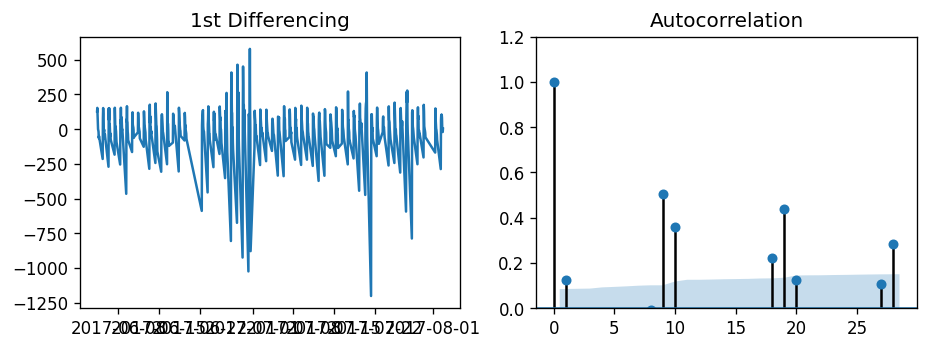

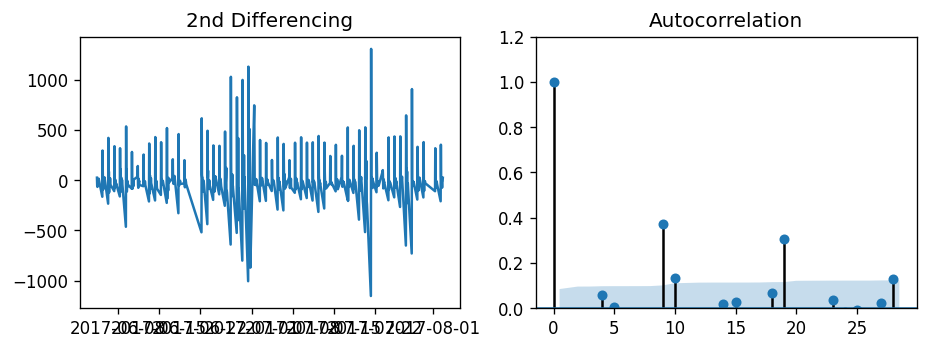

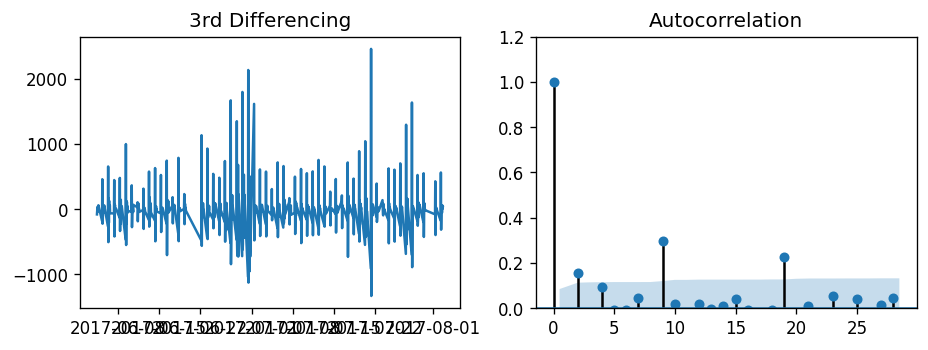

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

df = m0_train.copy()


fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.usage_max_per_hour.diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.usage_max_per_hour.diff().diff().dropna(), ax=axes[1])

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.usage_max_per_hour.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.usage_max_per_hour.diff().diff().diff().dropna(), ax=axes[1])

# q term is 3 for m0_train

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

ix = 0
for train_mun, test_mun in zip(train_muns, test_muns):

  print(f'Municipality Id: {ix}')

  model = ARIMA(train_mun['usage_max_per_hour'], order=(7, 0, 3)) # d=0 as our model is already stationary (p,d,q)
  results_ARIMA = model.fit()

  arima_preds = results_ARIMA.forecast(len(test_mun))[0]
  mse = mean_squared_error(test_mun['usage_max_per_hour'].values.tolist(), arima_preds)

  ix+=1

  print(f'Municipality {ix} MSE result: ', mse)
  print('-'*50)

In [ ]:
history = m0_train['usage_max_per_hour'].values.tolist()
predictions = list()
for t in range(len(m0_test)):
	model = ARIMA(history, order=(7,0,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = m0_test['usage_max_per_hour'].values.tolist()[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=524.684361, expected=252.000000
predicted=294.822521, expected=393.000000
predicted=453.013380, expected=517.000000
predicted=582.849615, expected=653.000000
predicted=657.169581, expected=655.000000
predicted=621.232421, expected=649.000000
predicted=669.739239, expected=622.000000
predicted=634.040430, expected=559.000000
predicted=494.034893, expected=483.000000
predicted=377.302322, expected=280.000000
predicted=288.142287, expected=391.000000
predicted=488.781161, expected=459.000000
predicted=596.090023, expected=569.000000
predicted=623.501092, expected=653.000000
predicted=617.722239, expected=658.000000
predicted=625.093830, expected=655.000000
predicted=613.449247, expected=645.000000
predicted=572.319037, expected=598.000000
predicted=503.193313, expected=530.000000
predicted=460.817300, expected=308.000000
predicted=352.566276, expected=435.000000
predicted=506.782767, expected=575.000000
predicted=634.074990, expected=647.000000
predicted=652.365888, expected=677

In [ ]:
mean_squared_error(m0_test['usage_max_per_hour'].values.tolist(), predictions)

12967.214308471619

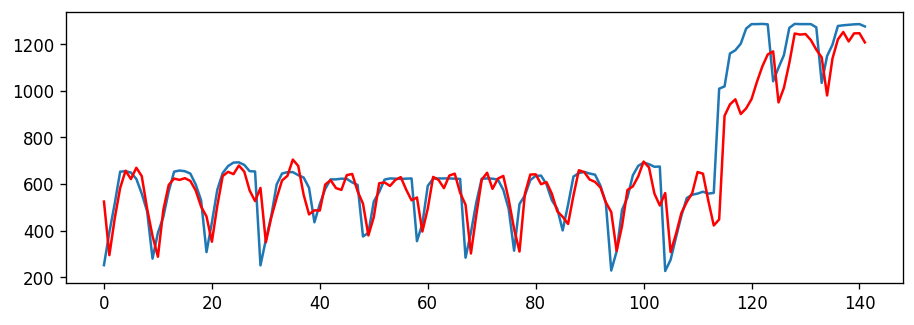

In [ ]:
from matplotlib import pyplot
# plot forecasts against actual outcomes
pyplot.plot(m0_test['usage_max_per_hour'].values.tolist())
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.usage_max_per_hour   No. Observations:                  531
Model:                   ARIMA(1, 1, 0)   Log Likelihood               -3323.496
Method:                         css-mle   S.D. of innovations            126.465
Date:                  Fri, 12 Aug 2022   AIC                           6652.992
Time:                          19:40:27   BIC                           6665.816
Sample:                               1   HQIC                          6658.011
                                                                                
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.3073      6.791      0.045      0.964     -13.003      13.617
ar.L1.D.usage_max_per_hour     0.1922      0.043      4.514      0.000       0.109       0.276
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.2027           +0.0000j            5.2027            0.0000
-----------------------------------------------------------------------------
"""

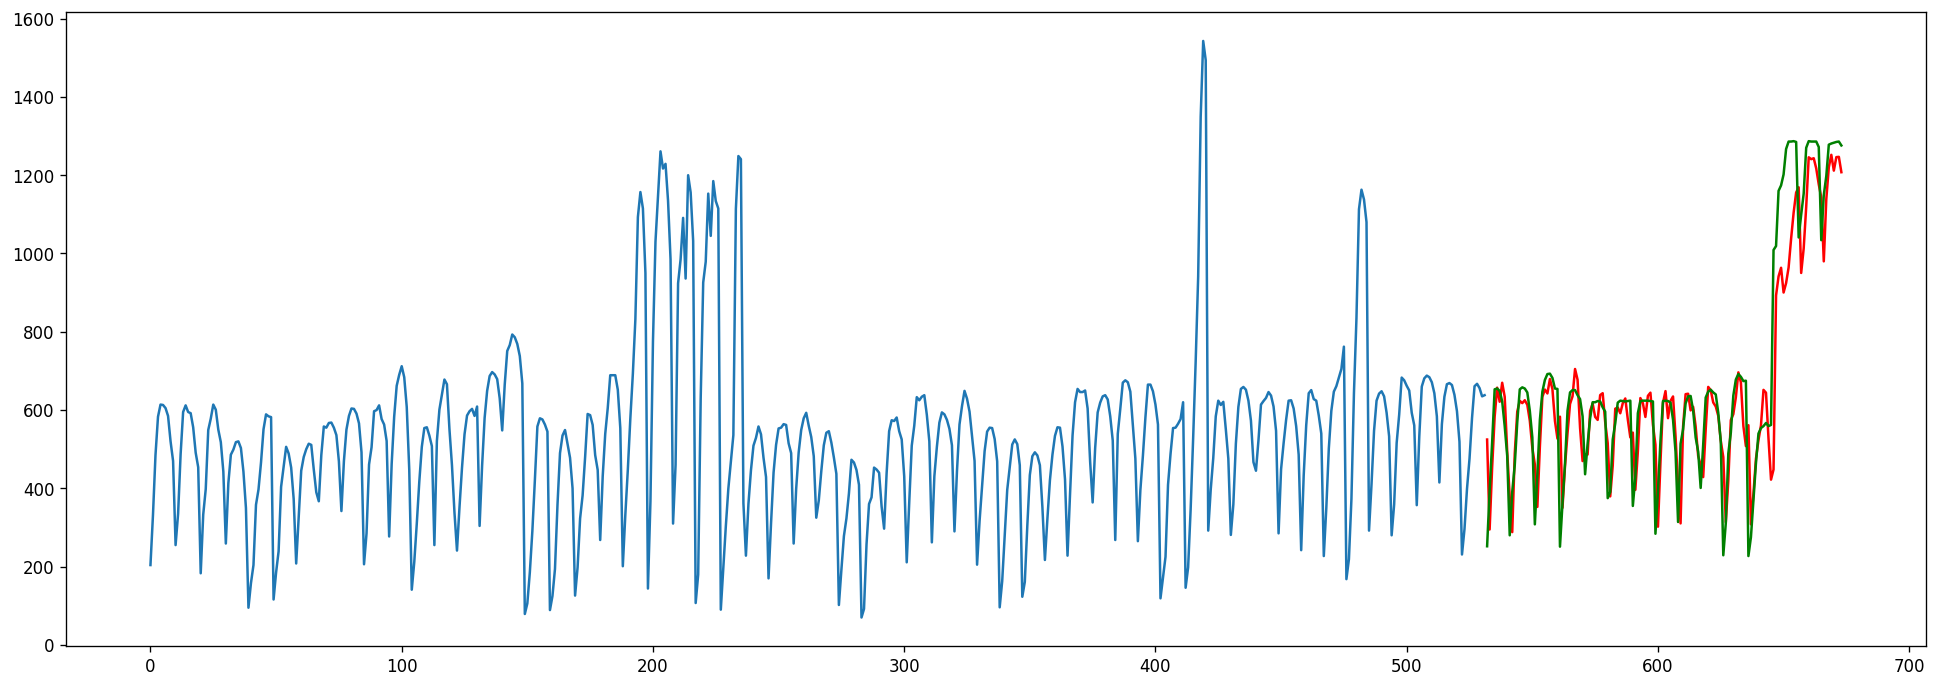

In [ ]:
plt.figure(figsize=(20,7))

plt.plot(range(len(m9_train)),m0_train['usage_max_per_hour'].values.tolist())
plt.plot(range(len(m9_train),len(m9_train)+len(m9_test)), predictions, c='r')
plt.plot(range(len(m9_train),len(m9_train)+len(m9_test)), m0_test['usage_max_per_hour'].values.tolist(), c='g')

# Set windows and horizons

In [126]:
HORIZON = 1
WINDOW_SIZE = 20

def format_data(x, horizon=HORIZON, window=WINDOW_SIZE, test=False):
  dict_ = {'m0_windows':[], 'm0_horizons':[],
           'm1_windows':[], 'm1_horizons':[],
           'm2_windows':[], 'm2_horizons':[],
           'm3_windows':[], 'm3_horizons':[],
           'm4_windows':[], 'm4_horizons':[],
           'm5_windows':[], 'm5_horizons':[],
           'm6_windows':[], 'm6_horizons':[],
           'm7_windows':[], 'm7_horizons':[],
           'm8_windows':[], 'm8_horizons':[],
           'm9_windows':[], 'm9_horizons':[]}

  for i in range(int(len(x))):
    if (i+window+horizon)<len(x):
      
      for ix,mun in enumerate(train_muns):
        dict_[f'm{ix}_windows'].append(mun.iloc[i:i+window,0].values.tolist())
      for ix,mun in enumerate(train_muns):
        dict_[f'm{ix}_horizons'].append(mun.iloc[i+window:i+window+horizon,0].values.tolist())
     
  if test:
    dict_t = {'m0_windows_t':[], 'm0_horizons_t':[],
              'm1_windows_t':[], 'm1_horizons_t':[],
              'm2_windows_t':[], 'm2_horizons_t':[],
              'm3_windows_t':[], 'm3_horizons_t':[],
              'm4_windows_t':[], 'm4_horizons_t':[],
              'm5_windows_t':[], 'm5_horizons_t':[],
              'm6_windows_t':[], 'm6_horizons_t':[],
              'm7_windows_t':[], 'm7_horizons_t':[],
              'm8_windows_t':[], 'm8_horizons_t':[],
              'm9_windows_t':[], 'm9_horizons_t':[]}
    for i in range(int(len(m0_test))):
      if (i+window+horizon)<len(m0_test):
  
        for ix,mun in enumerate(test_muns):
          dict_t[f'm{ix}_windows_t'].append(mun.iloc[i:i+window,0].values.tolist())
        for ix,mun in enumerate(test_muns):
          dict_t[f'm{ix}_horizons_t'].append(mun.iloc[i+window:i+window+horizon,0].values.tolist())
       

    return dict_, dict_t

  return dict_

In [127]:
train_dict, test_dict = format_data(m0_train, test=True)

# Convolutional Model

In [129]:
input_0 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer0')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_0)
out_0 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model0 = tf.keras.Model(inputs=input_0,
                        outputs=out_0)

input_1 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer1')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_1)
out_1 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model1 = tf.keras.Model(inputs=input_1,
                        outputs=out_1)

input_2 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer2')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_2)
out_2 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model2 = tf.keras.Model(inputs=input_2,
                        outputs=out_2)

input_3 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer3')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_3)
out_3 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model3 = tf.keras.Model(inputs=input_3,
                        outputs=out_3)

input_4 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer4')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_4)
out_4 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model4 = tf.keras.Model(inputs=input_4,
                        outputs=out_4)

input_5 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer5')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_5)
out_5 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model5 = tf.keras.Model(inputs=input_5,
                        outputs=out_5)

input_6 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer6')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_6)
out_6 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model6 = tf.keras.Model(inputs=input_6,
                        outputs=out_6)

input_7 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer7')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_7)
out_7 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model7 = tf.keras.Model(inputs=input_7,
                        outputs=out_7)

input_8 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer8')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_8)
out_8 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model8 = tf.keras.Model(inputs=input_8,
                        outputs=out_8)

input_9 = tf.keras.layers.Input(shape=[WINDOW_SIZE], name='input_layer9')
reshaped = tf.keras.layers.Reshape((WINDOW_SIZE,1))(input_9)
out_9 = tf.keras.layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(reshaped)
model9 = tf.keras.Model(inputs=input_9,
                        outputs=out_9)

output0 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model0.output)

output1 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model1.output)

output2 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model2.output)

output3 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model3.output)

output4 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model4.output)

output5 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model5.output)

output6 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model6.output)

output7 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model7.output)

output8 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model8.output)

output9 = tf.keras.layers.Dense(HORIZON, kernel_initializer='he_uniform')(model9.output)

conv_model = tf.keras.Model(inputs=[
  model0.input,
  model1.input,  
  model2.input,
  model3.input,
  model4.input,
  model5.input,
  model6.input,
  model7.input,
  model8.input,
  model9.input    
], outputs=[
  output0,
  output1,  
  output2,
  output3,
  output4,
  output5,
  output6,
  output7,
  output8,
  output9    
])

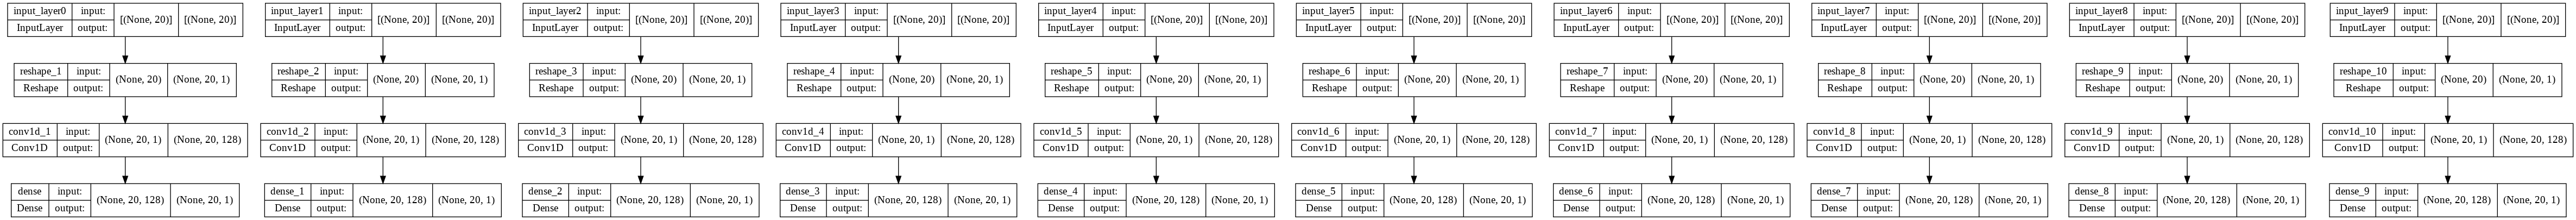

In [130]:
from tensorflow.keras.utils import plot_model
plot_model(conv_model, show_shapes=True)

In [ ]:
conv_model.summary()

Model: "model_252"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer0 (InputLayer)      [(None, 1, 14)]      0           []                               
                                                                                                  
 input_layer1 (InputLayer)      [(None, 1, 14)]      0           []                               
                                                                                                  
 input_layer2 (InputLayer)      [(None, 1, 14)]      0           []                               
                                                                                                  
 input_layer3 (InputLayer)      [(None, 1, 14)]      0           []                               
                                                                                          

In [138]:
conv_model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['mae'])

In [226]:
train_window_data = tf.data.Dataset.from_tensor_slices((train_dict['m0_windows'],
                                                        train_dict['m1_windows'],
                                                        train_dict['m2_windows'],
                                                        train_dict['m3_windows'],
                                                        train_dict['m4_windows'],
                                                        train_dict['m5_windows'],
                                                        train_dict['m6_windows'],
                                                        train_dict['m7_windows'],
                                                        train_dict['m8_windows'],
                                                        train_dict['m9_windows'],)) 

train_horizon_data = tf.data.Dataset.from_tensor_slices((train_dict['m0_horizons'],
                                                         train_dict['m1_horizons'],
                                                         train_dict['m2_horizons'],
                                                         train_dict['m3_horizons'],
                                                         train_dict['m4_horizons'],
                                                         train_dict['m5_horizons'],
                                                         train_dict['m6_horizons'],
                                                         train_dict['m7_horizons'],
                                                         train_dict['m8_horizons'],
                                                         train_dict['m9_horizons']))

train_CONV_dataset = tf.data.Dataset.zip((train_window_data, train_horizon_data)) 
train_CONV_dataset = train_CONV_dataset.batch(1).prefetch(tf.data.AUTOTUNE) 

test_window_data = tf.data.Dataset.from_tensor_slices((test_dict['m0_windows_t'],
                                                        test_dict['m1_windows_t'],
                                                        test_dict['m2_windows_t'],
                                                        test_dict['m3_windows_t'],
                                                        test_dict['m4_windows_t'],
                                                        test_dict['m5_windows_t'],
                                                        test_dict['m6_windows_t'],
                                                        test_dict['m7_windows_t'],
                                                        test_dict['m8_windows_t'],
                                                        test_dict['m9_windows_t'],)) 

test_horizon_data = tf.data.Dataset.from_tensor_slices((test_dict['m0_horizons_t'],
                                                         test_dict['m1_horizons_t'],
                                                         test_dict['m2_horizons_t'],
                                                         test_dict['m3_horizons_t'],
                                                         test_dict['m4_horizons_t'],
                                                         test_dict['m5_horizons_t'],
                                                         test_dict['m6_horizons_t'],
                                                         test_dict['m7_horizons_t'],
                                                         test_dict['m8_horizons_t'],
                                                         test_dict['m9_horizons_t']))

test_CONV_dataset = tf.data.Dataset.zip((test_window_data, test_horizon_data)) 
test_CONV_dataset = test_CONV_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

In [227]:
es = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [228]:
conv_model.fit(train_CONV_dataset,
          epochs=200,
          validation_data=test_CONV_dataset,
          callbacks=[es])

Epoch 1/200
511/511 [==============================] - 5s 8ms/step - loss: 2008766.5000 - dense_loss: 61004.9453 - dense_1_loss: 7821.2520 - dense_2_loss: 19317.5391 - dense_3_loss: 218203.5156 - dense_4_loss: 1303804.2500 - dense_5_loss: 12055.5420 - dense_6_loss: 112782.9375 - dense_7_loss: 94361.7812 - dense_8_loss: 141993.0156 - dense_9_loss: 37421.9375 - dense_mae: 181.9745 - dense_1_mae: 71.4597 - dense_2_mae: 111.2281 - dense_3_mae: 358.6526 - dense_4_mae: 873.1977 - dense_5_mae: 83.7702 - dense_6_mae: 260.1266 - dense_7_mae: 244.9996 - dense_8_mae: 291.3156 - dense_9_mae: 154.3202 - val_loss: 1394529.7500 - val_dense_loss: 69165.5234 - val_dense_1_loss: 8507.4941 - val_dense_2_loss: 20127.4082 - val_dense_3_loss: 152352.7031 - val_dense_4_loss: 833821.5000 - val_dense_5_loss: 15425.9854 - val_dense_6_loss: 66514.6328 - val_dense_7_loss: 89795.3750 - val_dense_8_loss: 100215.3984 - val_dense_9_loss: 38603.8984 - val_dense_mae: 180.4294 - val_dense_1_mae: 83.4706 - val_dense_2_ma

# SIMPLE DENSE MODEL

In [142]:
simple_dense = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

simple_dense.compile(loss='mse',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

simple_dense.fit(np.expand_dims(train_dict['m0_windows'], axis=0).astype(np.float64),
                np.expand_dims(train_dict['m0_horizons'], axis=0).astype(np.float64),
                epochs=170,
                validation_data = (np.expand_dims(test_dict['m0_windows_t'], axis=0).astype(np.float64), np.expand_dims(test_dict['m0_horizons_t'], axis=0).astype(np.float64)))

Epoch 1/170
1/1 [==============================] - 1s 721ms/step - loss: 214967.2344 - val_loss: 245540896.0000
Epoch 2/170
1/1 [==============================] - 0s 36ms/step - loss: 163649216.0000 - val_loss: 3952859.2500
Epoch 3/170
1/1 [==============================] - 0s 45ms/step - loss: 2928100.5000 - val_loss: 3729583.7500
Epoch 4/170
1/1 [==============================] - 0s 41ms/step - loss: 2280125.0000 - val_loss: 5852520.0000
Epoch 5/170
1/1 [==============================] - 0s 43ms/step - loss: 3641711.0000 - val_loss: 6734400.0000
Epoch 6/170
1/1 [==============================] - 0s 41ms/step - loss: 4205206.0000 - val_loss: 6605878.0000
Epoch 7/170
1/1 [==============================] - 0s 40ms/step - loss: 4123038.7500 - val_loss: 5766685.5000
Epoch 8/170
1/1 [==============================] - 0s 59ms/step - loss: 3587002.2500 - val_loss: 4623726.0000
Epoch 9/170
1/1 [==============================] - 0s 46ms/step - loss: 2859010.2500 - val_loss: 3488694.7500
Epoch 

In [143]:
simple_model_preds = []
preds_on = [*train_dict['m0_windows'][-1]]

for _ in range(14):
  pred = simple_dense.predict([preds_on]).item()
  preds_on.append(pred)
  del preds_on[0]
  simple_model_preds.append(pred)

In [144]:
simple_model_preds

[558.2435913085938,
 448.24530029296875,
 390.43475341796875,
 413.7947082519531,
 478.2874755859375,
 560.60302734375,
 610.0740966796875,
 641.8726806640625,
 654.3176879882812,
 595.79931640625,
 515.2734985351562,
 420.1282958984375,
 393.6023254394531,
 422.359130859375]

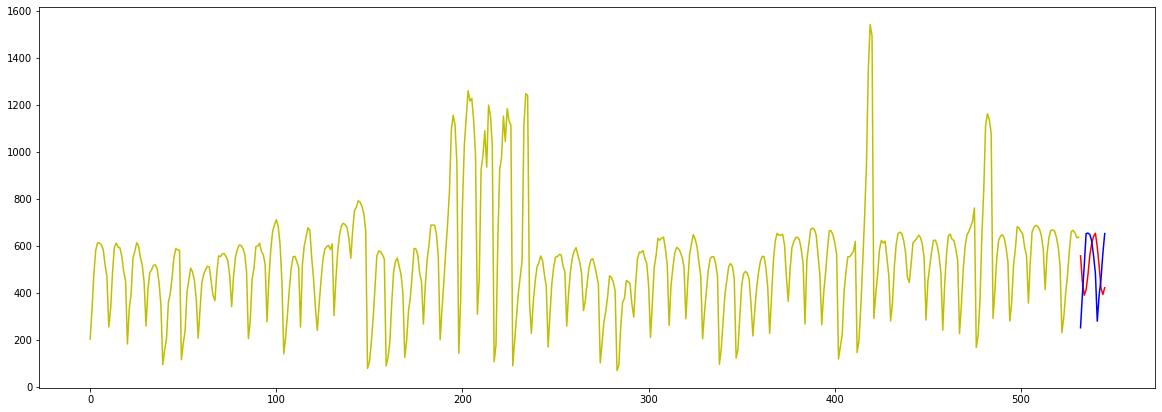

In [145]:
plt.figure(figsize=(20,7))

plt.plot(range(len(m0_train)),m0_train['usage_max_per_hour'].values.tolist(), c='y')
plt.plot(range(len(m0_train),len(m0_train)+14), simple_model_preds, c='r') 
plt.plot(range(len(m0_train),len(m0_train)+14), m0_test['usage_max_per_hour'].values.tolist()[:14], c='b') # real test results

# Simple LSTM model

In [167]:
simple_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

simple_LSTM.compile(loss='mse',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

simple_LSTM.fit(np.expand_dims(train_dict['m0_windows'], axis=-1).astype(np.float64),
                np.array(train_dict['m0_horizons']).astype(np.float64),
                epochs=300,
                callbacks=[es],
                validation_data = (np.expand_dims(test_dict['m0_windows_t'], axis=-1).astype(np.float64), np.array(test_dict['m0_horizons_t']).astype(np.float64)))

Epoch 1/300
16/16 [==============================] - 5s 81ms/step - loss: 305430.2812 - val_loss: 498911.9062
Epoch 2/300
16/16 [==============================] - 0s 28ms/step - loss: 248244.3281 - val_loss: 425983.0000
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 199960.6875 - val_loss: 363527.8438
Epoch 4/300
16/16 [==============================] - 0s 24ms/step - loss: 161005.2969 - val_loss: 311683.2812
Epoch 5/300
16/16 [==============================] - 0s 24ms/step - loss: 130355.1953 - val_loss: 269366.2812
Epoch 6/300
16/16 [==============================] - 0s 24ms/step - loss: 107156.9609 - val_loss: 234928.5000
Epoch 7/300
16/16 [==============================] - 0s 24ms/step - loss: 89623.8438 - val_loss: 207643.6719
Epoch 8/300
16/16 [==============================] - 0s 23ms/step - loss: 77080.2969 - val_loss: 185829.1719
Epoch 9/300
16/16 [==============================] - 0s 24ms/step - loss: 68106.1406 - val_loss: 168844.3281
Epoch 10/300


# nbeats

In [194]:
# Create NBeatsBlock custom layer
class NbeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments (parameters) for the parent class (e.g. input_shape, tarinable, name...). Parent class = 'tf.keras.layers.Layer' in paranthesis in 'class NbeatsBlock(tf.keras.layers.Layer):'
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)] 
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called. It is what defines the computation from the inputs to the outputs.
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [195]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(20, 21)

In [196]:
# Make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_dict['m0_windows'])
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_dict['m0_horizons'])

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_dict['m0_windows_t'])
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_dict['m0_horizons_t'])

# Combine features and labels -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>)

In [197]:
tf.random.set_seed(42)

nbeats_block_layer = NbeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")
residuals, forecast = nbeats_block_layer(stack_input)
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created 1 above so we need 29 stacks here which will be 30 in total
  backcast, block_forecast = NbeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}" 
  )(residuals) # pass in the residuals 

  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

model_1 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_NBEATS")

In [198]:
model_1.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam())

model_1_history = model_1.fit(train_dataset,
                              epochs=N_EPOCHS,
                              verbose=1,
                              validation_data=test_dataset, 
                              callbacks = [tf.keras.callbacks.EarlyStopping(patience=30,
                                                                            restore_best_weights=True),
                                           tf.keras.callbacks.ReduceLROnPlateau(patience=15,
                                                                                verbose=1)])

Epoch 1/5000
511/511 [==============================] - 61s 102ms/step - loss: 65745.1250 - val_loss: 45294.3633 - lr: 0.0010
Epoch 2/5000
511/511 [==============================] - 52s 101ms/step - loss: 65256.9258 - val_loss: 68804.6406 - lr: 0.0010
Epoch 3/5000
511/511 [==============================] - 51s 99ms/step - loss: 79953.3750 - val_loss: 82390.9688 - lr: 0.0010
Epoch 4/5000
511/511 [==============================] - 52s 103ms/step - loss: 46523.9805 - val_loss: 138321.7500 - lr: 0.0010
Epoch 5/5000
511/511 [==============================] - 52s 102ms/step - loss: 68122.8906 - val_loss: 97164.1797 - lr: 0.0010
Epoch 6/5000
511/511 [==============================] - 54s 105ms/step - loss: 70791.9297 - val_loss: 80948.6641 - lr: 0.0010
Epoch 7/5000
511/511 [==============================] - 50s 99ms/step - loss: 54197.6445 - val_loss: 102780.8438 - lr: 0.0010
Epoch 8/5000
511/511 [==============================] - 53s 103ms/step - loss: 65016.2852 - val_loss: 51381.9062 - lr:

In [221]:
nBeats_preds = model_1.predict(test_dict['m0_windows_t'])

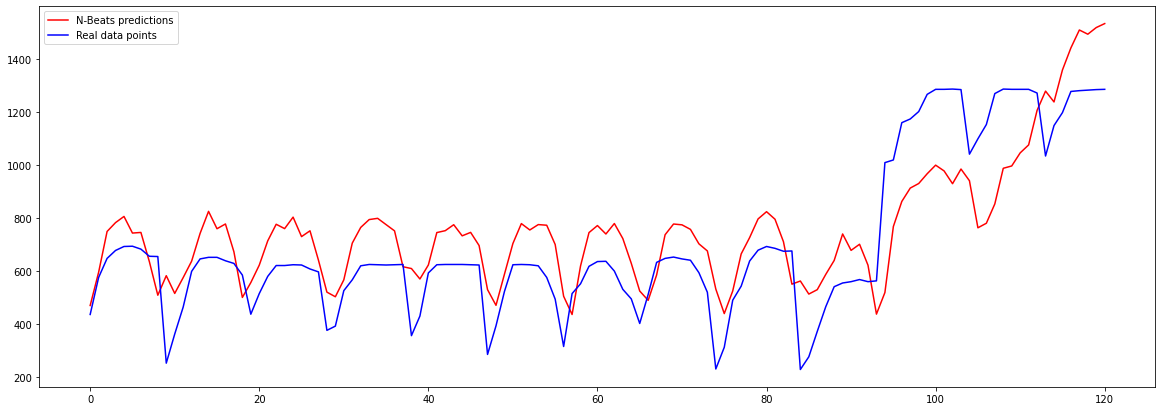

In [225]:
# N-Beats results graph
plt.figure(figsize=(20,7))

plt.plot(range(len(test_dict['m0_horizons_t'])), nBeats_preds, c='r', label='N-Beats predictions') # nbeats preds
plt.plot(range(len(test_dict['m0_horizons_t'])), test_dict['m0_horizons_t'], c='b', label='Real data points') # real test results
plt.legend()